# Model I: XGBoost

In [1]:
from datetime import timedelta, datetime
import itertools
import json
import matplotlib.pyplot as plt
from matplotlib import rcParams
import mlflow
import re
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import yaml
from tqdm import tqdm 
from datetime import timedelta
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, plotting, space_eval

# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd()
proj_path = current_dir.parent.parent

# make the code in src available to import in this notebook
import sys
sys.path.append(os.path.join(proj_path,'src'))
from glob import glob

import xgboost as xgb
from xgboost import XGBClassifier

from metrics import *
from utils import *

# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)['breakfast']
    
# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, 'conf/params.yml'), "r") as f:
    params = yaml.load(f,Loader=yaml.Loader)
    

In [2]:
space = {
        # Range passed for learning rate
       'eta': hp.quniform('eta', 0.02, 0.5, 0.01),
        # Control overfitting
        # Maximum depth of a tree: default 6 -> range: [0:∞]
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        # Minimum sum of instance weight (hessian) needed in a child: default 1
        'min_child_weight': hp.quniform('min_child_weight', 1, 3, 1),
        # Add randomness to make training robust to noise (control overfitting)
        # Subsample ratio of the training instance: default 1
        'subsample': hp.quniform('subsample', 0.2, 1, 0.1),
        # Subsample ratio of columns when constructing each tree: default 1
        'colsample_bytree': hp.quniform('colsample_bytree', 0.2, 1, 0.1),
        'n_estimators': hp.choice('n_estimators', np.arange(5, 150, dtype=int))
        }

#Search function that will return the parameter values for the optimized score
def optimize():
       
    # tpe.suggest is the algorithm used for updating the search space
    # trials are used to log the information
    # max_evals is used to specify how many combinations to look for

    best = fmin(_score, space, algo=tpe.suggest, trials=trials, max_evals=50,verbose=0)
   
    return best

Processing store 2277 upc 1600027527
Processing range 2009-01-17 to 2011-01-29


/Users/charboju/Desktop/Desktop2/temp-justin/feras-gig/src/utils.py:102: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())


CPU times: user 1min 18s, sys: 4.04 s, total: 1min 22s
Wall time: 14.6 s


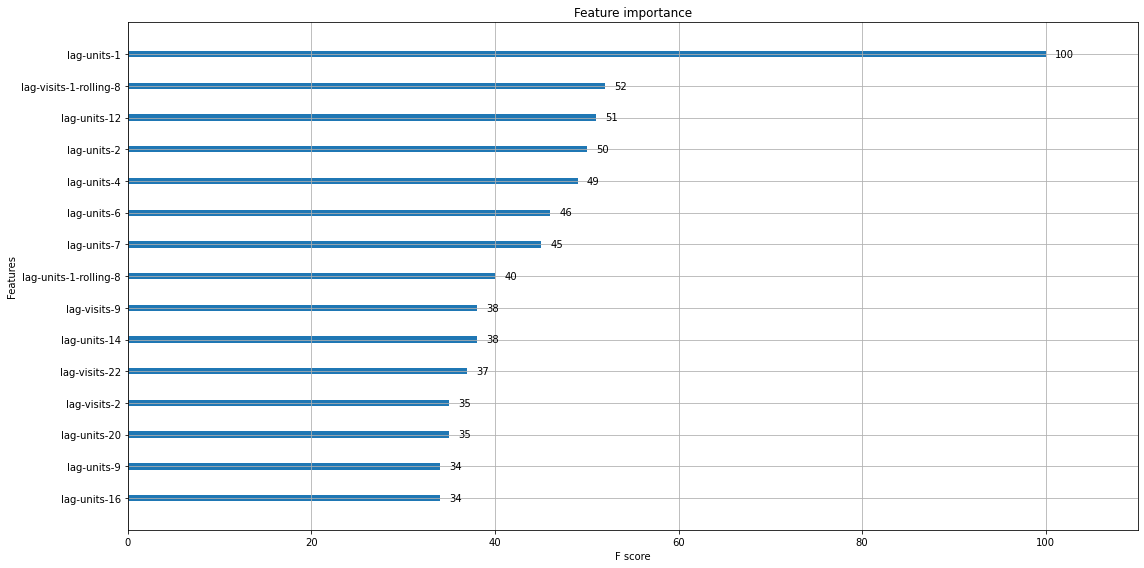

In [3]:
%%time

# Step 1: Read data and convert string to proper datetime objects
merged_data = pd.read_csv(os.path.join(proj_path, catalog['output_dir']['dir'], catalog['output_dir']['merged']))
merged_data['WEEK_END_DATE'] = pd.to_datetime(merged_data['WEEK_END_DATE'])
merged_data['WEEK_END_DATE'] = merged_data['WEEK_END_DATE'] + timedelta(days=3)

# Step2: Create date folds
date_ranges = make_dates(params['breakfast']['experiment_dates'])

# Step 3: Iterate over each store and upc pair.
# For each pair, iterate over each period (fold), find the optimal
# set of parameters for that fold and make the predictions
# on the test period
stores = list(params['breakfast']['dataset']['store_ids'].keys())
upcs = list(params['breakfast']['dataset']['upc_ids'].keys())
store_upc_pairs = list(itertools.product(stores, upcs))


for store_id, upc_id in store_upc_pairs: 
    print(f'Processing store {store_id} upc {upc_id}')
    
    create_folder(os.path.join(proj_path, 'mlruns'))
    mlflow.set_tracking_uri(os.path.join(proj_path, 'mlruns'))
    mlflow.set_experiment(f'{store_id}_{upc_id}')
    
    # Iterate over each period, unpack tuple in each variable.
    # in each of the period, we will find the best set of parameters,
    # which will represent the time-series cross validation methodology
    for _, train_start, train_end, valid_start, valid_end, test_start, test_end in date_ranges.itertuples():
        print(f'Processing range {str(train_start.date())} to {str(test_end.date())}')

        
        # allow the model to see past 6 months as features
        lag_units = params['xgb']['window_size']
        avg_units = params['xgb']['avg_units']

        
        # ADD MORE FEATURES HERE
        filtered_data = merged_data[(merged_data['STORE_NUM']==store_id) &
                                    (merged_data['UPC']==upc_id)][['UNITS','VISITS','HHS','FEATURE','DISPLAY','WEEK_END_DATE']].copy()


        # Add sale and date features (inplace) 
        # We do this on all the data, to avoid having NaN at the begining due to calculating the lags
        make_lag_features(filtered_data,lag_units,col_name='UNITS', prefix_name='lag-units',inplace=True)
        make_historical_avg(filtered_data, r_list=avg_units, col_n='lag-units-1', google_trends=True)
        
        # ADD Additional features here!
        make_lag_features(filtered_data,lag_units,col_name='VISITS',prefix_name='lag-visits',inplace=True)
        make_lag_features(filtered_data,lag_units,col_name='HHS',prefix_name='lag-hss',inplace=True)
        make_lag_features(filtered_data,lag_units,col_name='FEATURE',prefix_name='lag-feature',inplace=True)
        make_lag_features(filtered_data,lag_units,col_name='DISPLAY',prefix_name='lag-display',inplace=True)
        
        make_historical_avg(filtered_data, r_list=avg_units, col_n='lag-visits-1', google_trends=True)
        make_historical_avg(filtered_data, r_list=avg_units, col_n='lag-hss-1', google_trends=True)
        make_historical_avg(filtered_data, r_list=avg_units, col_n='lag-feature-1', google_trends=True)
        make_historical_avg(filtered_data, r_list=avg_units, col_n='lag-display-1', google_trends=True)    
        
        # cols should be shifted from lag_features.
        filtered_data.drop(columns=['VISITS','HHS','FEATURE','DISPLAY'], axis='columns',inplace=True)
#         training_df.drop(columns=['VISITS','HHS','FEATURE','DISPLAY'], axis='columns',inplace=True)
#         test_df.drop(columns=['VISITS','HHS','FEATURE','DISPLAY'], axis='columns',inplace=True)
        
        add_datepart(filtered_data, fldname='WEEK_END_DATE', drop=False)
        # Filter data
        training_df = filtered_data[(filtered_data['WEEK_END_DATE']>=train_start) &
                                    (filtered_data['WEEK_END_DATE']<=train_end)].copy()

        valid_df = filtered_data[(filtered_data['WEEK_END_DATE']>=valid_start) &
                                 (filtered_data['WEEK_END_DATE']<=valid_end)].copy()

        test_df = filtered_data[(filtered_data['WEEK_END_DATE']>=test_start) &
                                (filtered_data['WEEK_END_DATE']<=test_end)].copy()
        training_df.set_index('WEEK_END_DATE', inplace=True)
        valid_df.set_index('WEEK_END_DATE', inplace=True)
        test_df.set_index('WEEK_END_DATE', inplace=True)

        X_train = training_df
        y_train = X_train.pop('UNITS')
        X_valid = valid_df
        y_valid = X_valid.pop('UNITS')
        X_test = test_df
        y_test = X_test.pop('UNITS')

        #Function used to perform an evaluation on the validation set and return the score to the optimized function
        def _score(params):
            xg_boost_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                              colsample_bytree = params['colsample_bytree'],
                                              learning_rate = params['eta'],
                                              max_depth = params['max_depth'],
                                              min_child_weight = params['min_child_weight'],
                                              n_estimators = params['n_estimators'],
                                              random_state = 2020,
                                              subsample = params['subsample'],
                                              tree_method = 'hist')
            xg_boost_model.fit(X_train, y_train)
            preds = xg_boost_model.predict(X_valid)
            mape = mean_absolute_percentage_error(y_valid, preds)
            return mape

        trials = Trials()
        best_hyperparams = optimize()
        hyperparams = space_eval(space, best_hyperparams)

        xgb_model = XGBClassifier(hyperparams)
        # Concat training with validation data
        xgb_model.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

        test_preds = xgb_model.predict(X_test)
        
        test_df['test_predictions'] = test_preds
        test_df['y_true'] = y_test
        test_metrics = get_metrics(test_df['y_true'].values, 
                                   test_df['test_predictions'].values)
        
        fdir = os.path.join(proj_path, catalog['results']['dir'], f'{str(test_end.date())}')
        fname = os.path.join(fdir, f'xgb_exp3_{store_id}_{upc_id}.csv')
        create_folder(fdir)

        # Save plot importance
        rcParams.update({'figure.autolayout': True}) # for saving in correct size
        fig, ax = plt.subplots(figsize=(16, 8))
        xgb.plot_importance(xgb_model, max_num_features=15, ax=ax)
        plot_dir = proj_path / 'data/05_extra' / f'{str(test_end.date())}'
        plot_name = plot_dir / f'xgb_exp3_{store_id}_{upc_id}.png'
        create_folder(plot_dir)            
        plt.savefig(plot_name)

        test_df.to_csv(fname)

        with mlflow.start_run():
            mlflow.log_param('model','xgb')
            mlflow.log_param('experiment','exp3')
            mlflow.log_params(hyperparams)
            mlflow.log_params(params['xgb'])
            mlflow.log_metrics(test_metrics)
            mlflow.log_artifact(plot_name)
            mlflow.log_artifact(fname)
            mlflow.log_params({'g_cat_state':False,
                               'g_cat_us':False,
                               'g_cc_state':False,
                               'g_cc_us':False})
        